# cMLP; F = 40; T = 1000; Layers = 1


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96
from cmlp import cMLP, train_model_ista

In [ ]:
# For GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Simulate data
X_np, GC = simulate_lorenz_96(p=20, F=40, T=1000)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

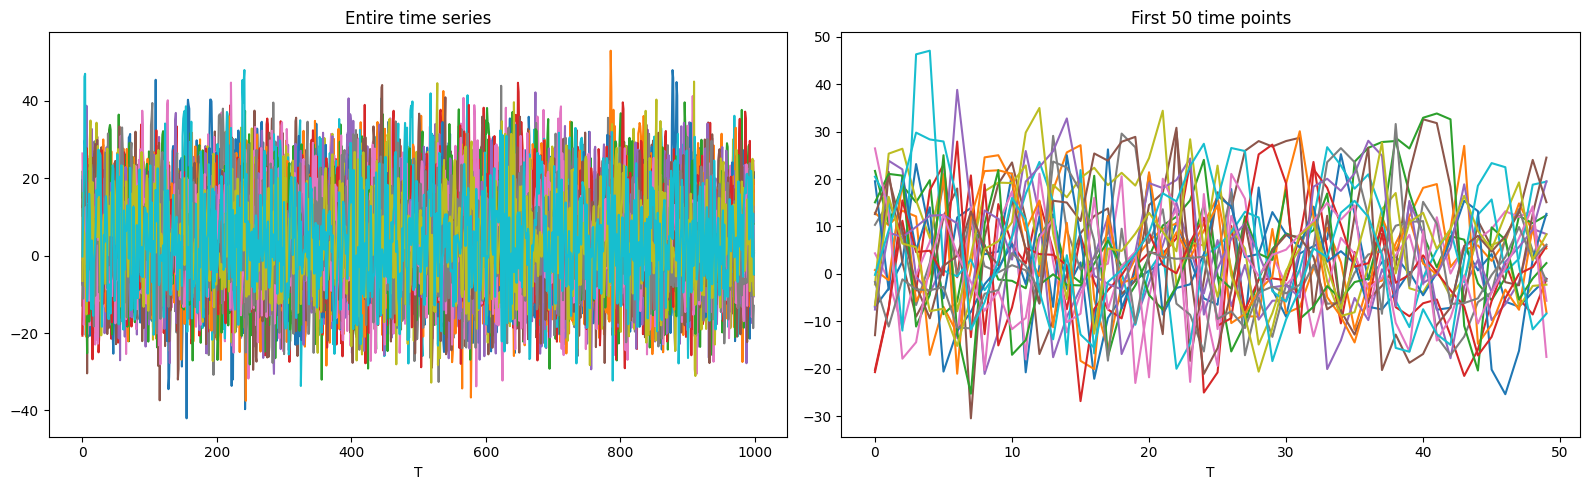

In [6]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()

plt.show()

----------Iter = 100----------
Loss = 176.321442
Variable usage = 1.25%
----------Iter = 200----------
Loss = 175.807907
Variable usage = 0.25%
----------Iter = 300----------
Loss = 175.357040
Variable usage = 0.25%
----------Iter = 400----------
Loss = 174.918991
Variable usage = 0.25%
----------Iter = 500----------
Loss = 174.490982
Variable usage = 0.25%
----------Iter = 600----------
Loss = 174.071823
Variable usage = 0.00%
----------Iter = 700----------
Loss = 173.661560
Variable usage = 0.00%
----------Iter = 800----------
Loss = 173.260300
Variable usage = 0.00%
----------Iter = 900----------
Loss = 172.867477
Variable usage = 0.25%
----------Iter = 1000----------
Loss = 172.481155
Variable usage = 0.00%
----------Iter = 1100----------
Loss = 172.101181
Variable usage = 0.00%
----------Iter = 1200----------
Loss = 171.725708
Variable usage = 0.00%
----------Iter = 1300----------
Loss = 171.354614
Variable usage = 0.25%
----------Iter = 1400----------
Loss = 170.985474
Variable u

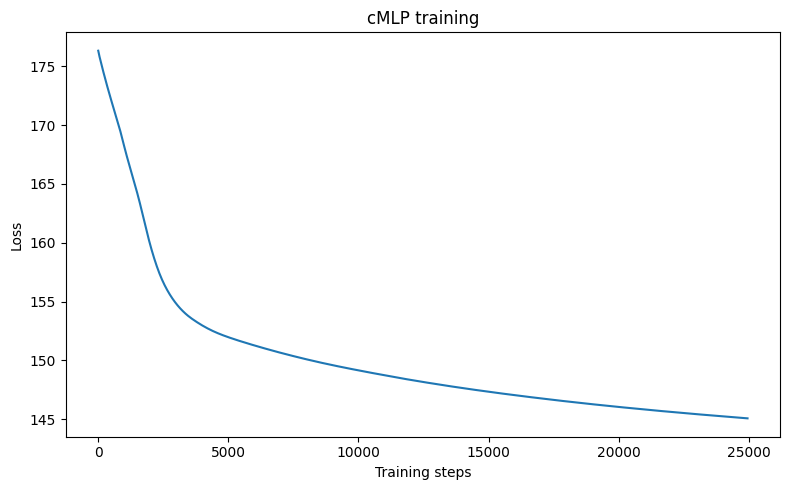

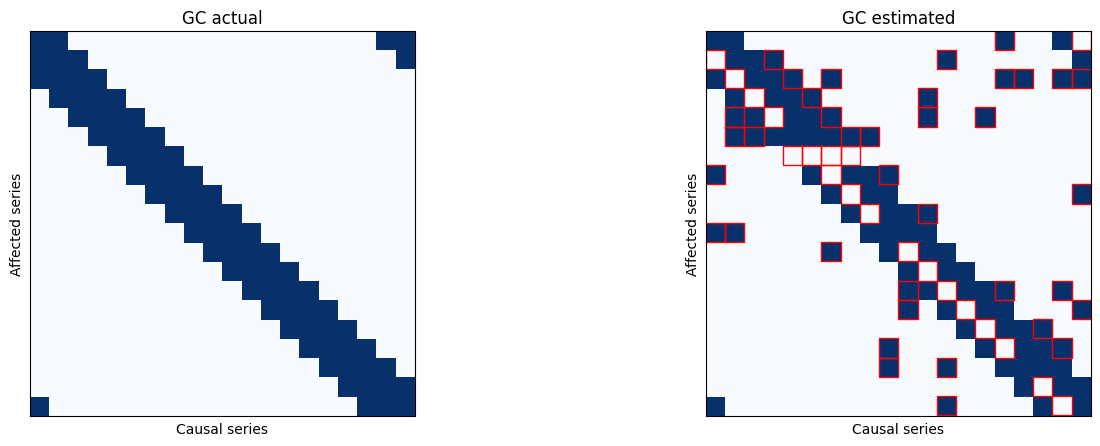

In [5]:
  #Set up model
  cmlp = cMLP(X.shape[-1], hidden=[10], lag=5).to(device=device)

  # Train with ISTA
  train_loss_list = train_model_ista(
    cmlp, X, lam=91, lam_ridge=1e-5, lr=5e-5, penalty='H', max_iter=50000,
    check_every=100)

  # Loss function plot
  plt.figure(figsize=(8, 5))
  train_loss_np = [loss.cpu().detach().numpy() for loss in train_loss_list]
  plt.plot(50 * np.arange(len(train_loss_np)), train_loss_np)
  plt.title('cMLP training')
  plt.ylabel('Loss')
  plt.xlabel('Training steps')
  plt.tight_layout()
  plt.show()

  # Verify learned Granger causality
  GC_est = cmlp.GC().cpu().data.numpy()

  # Make figures for Granger causality matrices
  fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
  axarr[0].imshow(GC, cmap='Blues')
  axarr[0].set_title('GC actual')
  axarr[0].set_ylabel('Affected series')
  axarr[0].set_xlabel('Causal series')
  axarr[0].set_xticks([])
  axarr[0].set_yticks([])

  axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
  axarr[1].set_title('GC estimated')
  axarr[1].set_ylabel('Affected series')
  axarr[1].set_xlabel('Causal series')
  axarr[1].set_xticks([])
  axarr[1].set_yticks([])

  # Mark disagreements
  for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

  plt.show()